In [1]:
import torch 
import argparse
import yaml
import time
import multiprocessing as mp
import torch.nn.functional as F
from tabulate import tabulate
from tqdm import tqdm
from torch.utils.data import DataLoader
from pathlib import Path
#from torch.utils.tensorboard import SummaryWriter
from torch.cuda.amp import GradScaler, autocast
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import DistributedSampler, RandomSampler
from torch import distributed as dist
from nmc.models import *
from nmc.datasets import * 
from nmc.augmentations import get_train_augmentation, get_val_augmentation
from nmc.losses import get_loss
from nmc.schedulers import get_scheduler
from nmc.optimizers import get_optimizer
from nmc.utils.utils import fix_seeds, setup_cudnn, cleanup_ddp, setup_ddp
from tools.val import evaluate_epi
from nmc.utils.episodic_utils import * 
from scipy.cluster import hierarchy
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn as nn
from torch.optim import lr_scheduler
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mutual_info_score
from scipy.cluster import hierarchy
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss
from torch.utils.data import Dataset, DataLoader, Sampler


In [ ]:
with open('configs/NMC.yaml') as f:
    cfg = yaml.load(f, Loader=yaml.SafeLoader)
print(cfg)
fix_seeds(3407)
setup_cudnn()
gpu = setup_ddp()
save_dir = Path(cfg['SAVE_DIR'])
save_dir.mkdir(exist_ok=True)
cleanup_ddp()

{'DEVICE': 'cuda:1', 'SAVE_DIR': 'output', 'MODEL': {'NAME': 'FGMaxxVit', 'BACKBONE': 'FGMaxxVit', 'PRETRAINED': 'checkpoints/pretrained/maxvit_base_tf_512.in1k_pretrained_weights.pth', 'UNFREEZE': 'full', 'VERSION': 'ImageNet_APTOS_1024'}, 'DATASET': {'NAME': 'NMCDataset', 'ROOT': '/data/nmc/processed_image', 'TRAIN_RATIO': 0.7, 'VALID_RATIO': 0.15, 'TEST_RATIO': 0.15}, 'TRAIN': {'IMAGE_SIZE': [512, 512], 'BATCH_SIZE': 32, 'EPOCHS': 100, 'EVAL_INTERVAL': 25, 'AMP': False, 'DDP': False}, 'LOSS': {'NAME': 'BCEWithLogitsLoss', 'CLS_WEIGHTS': False}, 'OPTIMIZER': {'NAME': 'adamw', 'LR': 0.001, 'WEIGHT_DECAY': 0.01}, 'SCHEDULER': {'NAME': 'warmuppolylr', 'POWER': 0.9, 'WARMUP': 10, 'WARMUP_RATIO': 0.1}, 'EVAL': {'MODEL_PATH': 'checkpoints/pretrained/FGMaxxVit/FGMaxxVit.FGMaxxVit.NMC.pth', 'IMAGE_SIZE': [512, 512]}, 'TEST': {'MODEL_PATH': 'checkpoints/pretrained/FGMaxxVit/FGMaxxVit.FGMaxxVit.NMC.pth', 'FILE': 'assests/ade', 'IMAGE_SIZE': [512, 512], 'OVERLAY': True}}


In [3]:
def extract_labels(dataloader):
    all_labels = []
    for _, labels in tqdm(dataloader, desc="Extracting labels"):
        all_labels.append(labels.numpy())
    return np.vstack(all_labels)
def calculate_mutual_info_matrix(label_matrix):
    n_labels = label_matrix.shape[1]
    mi_matrix = np.zeros((n_labels, n_labels))
    for i in range(n_labels):
        for j in range(i, n_labels):
            mi = mutual_info_score(label_matrix[:, i], label_matrix[:, j])
            mi_matrix[i, j] = mi
            mi_matrix[j, i] = mi
    return mi_matrix
def plot_heatmap(matrix, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=False, cmap='coolwarm')
    plt.title(title)
    plt.show()
def analyze_trainloader_labels(trainloader):
    # 라벨 추출
    label_matrix = extract_labels(trainloader)

    # 상호 정보량 매트릭스 계산 및 시각화
    mi_matrix = calculate_mutual_info_matrix(label_matrix)
    plot_heatmap(mi_matrix, 'Label Mutual Information Matrix')
    return mi_matrix
def select_most_independent_labels(mi_matrix):
    linkage = hierarchy.linkage(mi_matrix, method='average')
    
    n_labels = mi_matrix.shape[0]
    ordered_labels = []
    remaining_clusters = list(range(2 * n_labels - 1))
    
    while len(ordered_labels) < n_labels:
        heights = [linkage[i-n_labels, 2] if i >= n_labels else 0 for i in remaining_clusters]
        max_height_idx = np.argmax(heights)
        selected_cluster = remaining_clusters[max_height_idx]
        
        if selected_cluster < n_labels:
            if selected_cluster not in ordered_labels:
                ordered_labels.append(selected_cluster)
            remaining_clusters.remove(selected_cluster)
        else:
            left, right = linkage[selected_cluster - n_labels, :2].astype(int)
            for child in [left, right]:
                if child < n_labels and child not in ordered_labels:
                    ordered_labels.append(child)
            remaining_clusters.remove(selected_cluster)
        
        # 모든 라벨이 선택되었다면 종료
        if len(ordered_labels) == n_labels:
            break
    
    return ordered_labels

In [4]:
start = time.time()
best_mf1 = 0.0
device = torch.device(cfg['DEVICE'])
print("device : ",device)
num_workers = mp.cpu_count()
train_cfg, eval_cfg = cfg['TRAIN'], cfg['EVAL']
dataset_cfg, model_cfg = cfg['DATASET'], cfg['MODEL']
loss_cfg, optim_cfg, sched_cfg = cfg['LOSS'], cfg['OPTIMIZER'], cfg['SCHEDULER']
epochs, lr = train_cfg['EPOCHS'], optim_cfg['LR']

image_dir = Path(dataset_cfg['ROOT']) / 'train_images'
transformations = get_train_augmentation(train_cfg['IMAGE_SIZE'])
batch_size = 32

dataset = eval(dataset_cfg['NAME'])(dataset_cfg['ROOT']+'/combined_images',dataset_cfg['TRAIN_RATIO'], dataset_cfg['VALID_RATIO'], dataset_cfg['TEST_RATIO'],  transformations)
trainset, valset, testset = dataset.get_splits()
# trainloader = DataLoader(trainset, batch_size=batch_size, num_workers=num_workers, drop_last=True, pin_memory=True)
valloader = DataLoader(valset, batch_size=1, num_workers=1, pin_memory=True)
testloader = DataLoader(testset, batch_size=1, num_workers=1, pin_memory=True)

device :  cuda:1
/data/nmc/processed_image/combined_images
(0,)             148
(0, 10)          110
(10,)             56
(0, 9, 10)        41
(0, 9)            41
                ... 
(1, 8, 9, 10)      1
(3, 4, 9, 10)      1
(5,)               1
(1, 2, 9, 10)      1
(3, 4)             1
Name: label, Length: 65, dtype: int64
train size: 686
(0,)                30
(0, 10)             25
(0, 9)              10
(0, 9, 10)           8
(9, 10)              5
(2, 10)              5
(1, 2)               4
(3, 10)              3
(1, 2, 3)            3
(1, 2, 3, 8)         3
(1, 10)              3
(8, 10)              2
(2, 8, 10)           2
(1, 2, 8, 10)        2
(0, 8)               2
(1, 2, 8, 9)         2
(1, 2, 3, 8, 10)     2
(1, 9, 10)           2
(0, 8, 10)           1
(1, 2, 5, 8)         1
(1, 2, 3, 9)         1
(1, 2, 9, 10)        1
(5, 8, 9, 10)        1
(2, 9, 10)           1
(2, 4)               1
(1, 2, 3, 4)         1
(3, 9)               1
(1, 4, 9, 10)        1
(2, 3, 9)   

In [5]:
len(trainset)

686

Extracting labels: 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]


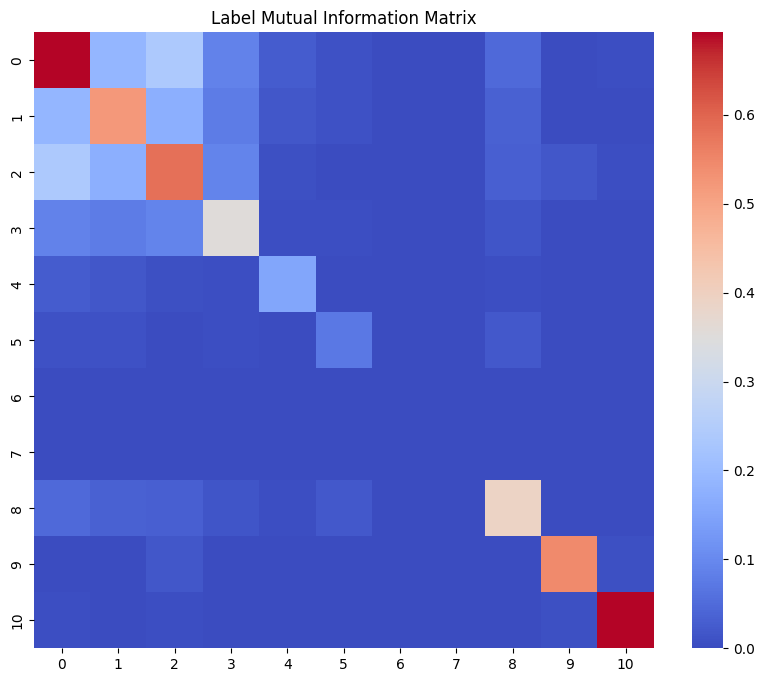

In [6]:
mi_matrix = analyze_trainloader_labels(trainloader)

In [5]:
def calculate_metrics(all_preds, all_labels):
    # PyTorch 텐서를 CPU로 이동하고 NumPy 배열로 변환
    all_preds = all_preds.cpu().numpy()
    all_labels = all_labels.cpu().numpy()
    
    # 예측값을 0 또는 1로 변환 (임계값 0.5 사용)
    pred_binary = (all_preds > 0.5).astype(int)
    
    # 실제 데이터에 존재하는 클래스 인덱스 찾기
    active_classes = np.where(np.sum(all_labels, axis=0) > 0)[0]
    
    # 전체 정확도 계산
    accuracy = accuracy_score(all_labels, pred_binary)
    
    # 각 클래스별 F1 점수, 정밀도, 재현율 계산 (활성 클래스만)
    f1_scores = f1_score(all_labels[:, active_classes], pred_binary[:, active_classes], average=None, zero_division=0)
    precision_scores = precision_score(all_labels[:, active_classes], pred_binary[:, active_classes], average=None, zero_division=0)
    recall_scores = recall_score(all_labels[:, active_classes], pred_binary[:, active_classes], average=None, zero_division=0)
    
    # Hamming Loss 계산
    hamming = hamming_loss(all_labels, pred_binary)
    
    # 샘플당 정확히 모든 라벨을 맞춘 비율 (Subset Accuracy)
    subset_accuracy = (all_labels == pred_binary).all(axis=1).mean()
    
    return {
        'accuracy': accuracy,
        'hamming_loss': hamming,
        'subset_accuracy': subset_accuracy,
        'f1_scores': f1_scores,
        'precision_scores': precision_scores,
        'recall_scores': recall_scores,
        'active_classes': active_classes
    }

def print_metrics(metrics):
    print("=== Overall Metrics ===")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Hamming Loss: {metrics['hamming_loss']:.4f}")
    print(f"Subset Accuracy: {metrics['subset_accuracy']:.4f}")
    print("\n=== Class-wise Metrics ===")
    print("Class\t\tF1 Score\tPrecision\tRecall")
    print("-" * 50)
    for i, class_idx in enumerate(metrics['active_classes']):
        print(f"Class {class_idx}:\t{metrics['f1_scores'][i]:.4f}\t\t{metrics['precision_scores'][i]:.4f}\t\t{metrics['recall_scores'][i]:.4f}")
    
    print("\n=###############== Average Metrics (Active Classes) ==###############=")
    print(f"Macro F1: {np.mean(metrics['f1_scores']):.4f}")
    print(f"Macro Precision: {np.mean(metrics['precision_scores']):.4f}")
    print(f"Macro Recall: {np.mean(metrics['recall_scores']):.4f}")

In [6]:
class BalancedMultiLabelSampler(Sampler):
    def __init__(self, labels, batch_size, update_interval):
        self.labels = labels
        self.num_samples = len(labels)
        self.num_classes = labels.shape[1]

        class_counts = np.sum(labels, axis=0)
        class_probs = np.zeros_like(class_counts, dtype=float)
        non_zero_classes = class_counts > 0
        class_probs[non_zero_classes] = 1 / class_counts[non_zero_classes]
        class_probs /= np.sum(class_probs)
        self.class_probs = class_probs
        self.batch_size = batch_size
        self.update_interval = update_interval

    def update_probs(self, class_losses):
        self.class_probs = class_losses / np.sum(class_losses)
    
    def calculate_target_ratios(self, prob_ratio=0.4, min_class_count=1):
        # prob_ratio: 확률에 기반한 비율 (0.0 ~ 1.0)
        # min_class_count: 각 클래스의 최소 등장 횟수

        # 최소 클래스 카운트 적용 (원래 확률이 0인 클래스는 제외)
        base_ratios = np.where(self.class_probs > 0, min_class_count, 0)
        remaining = self.batch_size - np.sum(base_ratios)

        if remaining <= 0:
            return base_ratios  # 배치 크기가 충분하지 않으면 최소 카운트만 반환

        # 확률에 기반한 할당
        prob_based_samples = int(remaining * prob_ratio)
        prob_based_ratios = (self.class_probs * prob_based_samples).astype(int)

        # 랜덤 할당
        random_samples = remaining - prob_based_samples
        non_zero_probs = self.class_probs > 0
        random_ratios = np.zeros_like(prob_based_ratios)
        if random_samples > 0 and np.sum(non_zero_probs) > 0:
            random_ratios[non_zero_probs] = np.random.multinomial(
                random_samples, 
                self.class_probs[non_zero_probs] / np.sum(self.class_probs[non_zero_probs])
            )

        # 모든 비율 합치기
        target_ratios = base_ratios + prob_based_ratios + random_ratios

        # 남은 샘플 처리 (반올림 오차로 인해 발생할 수 있음)
        remaining = self.batch_size - np.sum(target_ratios)
        if remaining > 0:
            # 남은 샘플을 확률이 0이 아닌 클래스에 랜덤하게 할당
            additional = np.random.multinomial(
                remaining, 
                self.class_probs[non_zero_probs] / np.sum(self.class_probs[non_zero_probs]),
                size=1
            )[0]
            target_ratios[non_zero_probs] += additional

        return target_ratios
    
    def select_class(self, target_class_ratios, current_class_counts):
        # 목표 비율과 현재 카운트의 차이 계산
        diff = target_class_ratios - current_class_counts
        
        # target_class_ratios가 0보다 큰 클래스 중에서만 선택
        valid_classes = np.where((diff > 0) & (target_class_ratios > 0))[0]
        
        if len(valid_classes) > 0:
            # 유효한 클래스 중 차이가 가장 큰 클래스 선택
            return valid_classes[np.argmax(diff[valid_classes])]
        else:
            # 모든 목표가 충족되었거나 유효한 클래스가 없다면,
            # target_class_ratios가 0보다 큰 클래스 중에서만 무작위 선택
            non_zero_targets = np.where(target_class_ratios > 0)[0]
            if len(non_zero_targets) > 0:
                return np.random.choice(non_zero_targets)
            else:
                # 모든 target_class_ratios가 0이라면 None 반환
                return None
        
    def select_sample_from_class(self, selected_class, available_indices):
        # 선택된 클래스에 속하는 샘플들의 인덱스 찾기
        class_samples = [idx for idx in available_indices if self.labels[idx, selected_class] == 1]
        if class_samples:
            # 해당 클래스의 샘플 중 무작위 선택
            return np.random.choice(class_samples)
        else:
            # 해당 클래스의 샘플이 없다면 None 반환
            return None
        
    def __iter__(self):
        # 전체 데이터셋 크기에 맞는 인덱스 배열 생성
        original_indices = np.arange(self.num_samples)
        
        for _ in range(self.update_interval):
            # 목표 클래스 비율 계산 (class_losses 기반)
            target_class_ratios = self.calculate_target_ratios()
            
            batch = []
            current_class_counts = np.zeros(self.num_classes)
            available_indices = original_indices.copy()
            
            while len(batch) < self.batch_size:
                # 목표 비율과 현재 배치 구성을 고려하여 클래스 선택
                selected_class = self.select_class(target_class_ratios, current_class_counts)
                if selected_class is None:
                    # 모든 클래스가 목표에 도달했다면, 남은 공간을 랜덤하게 채움
                    remaining = self.batch_size - len(batch)
                    batch.extend(np.random.choice(original_indices, size=remaining, replace=True))
                    break
                
                # 선택된 클래스를 포함하는 샘플 중에서 선택
                sample_idx = self.select_sample_from_class(selected_class, available_indices)
                
                if sample_idx is None:
                    # 해당 클래스의 모든 샘플을 사용했다면, 원본 인덱스에서 다시 선택
                    class_samples = [idx for idx in original_indices if self.labels[idx, selected_class] == 1]
                    if class_samples:
                        sample_idx = np.random.choice(class_samples)
                    else:
                        continue  # 해당 클래스의 샘플이 없다면 다른 클래스 선택
                
                batch.append(sample_idx)
                current_class_counts += self.labels[sample_idx]
                available_indices = np.setdiff1d(available_indices, [sample_idx])
            
            yield batch

    def __len__(self):
        return (self.num_samples + self.batch_size - 1) // self.batch_size

In [7]:
# 모델 및 데이터 설정 (이전과 동일)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = models.resnet50(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, dataset.n_classes)
resnet = resnet.to(device)

optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss(reduction='none')

train_labels = dataset.train_data[1]  # 원-핫 인코딩된 레이블

batch_size = 64
total_batches = 100  # 원하는 총 배치 수
eval_interval = 1  # 평가 간격 (배치 단위)
sampler = BalancedMultiLabelSampler(train_labels,batch_size,eval_interval)

total_loss = 0
all_losses = []

for batch in tqdm(range(total_batches), desc="Training Progress"):
    resnet.train()
    
    # 매 배치마다 새로운 DataLoader 생성
    trainloader = DataLoader(trainset,  batch_sampler=sampler)
    img, lbl = next(iter(trainloader))
    
    img = img.to(device)
    lbl = lbl.to(device)
    
    optimizer.zero_grad()
    
    outputs = resnet(img)
    losses = criterion(outputs, lbl)
    loss = losses.mean()
    
    loss.backward()
    optimizer.step()
    
    total_loss += loss.item()
    all_losses.append(losses.detach().cpu().numpy())
    
    if (batch + 1) % eval_interval == 0:
        avg_loss = total_loss / eval_interval
        print(f"Batch {batch + 1}/{total_batches}, Average Loss: {avg_loss:.4f}")
        
        # 클래스별 평균 손실 계산 및 샘플러 업데이트
        batch_losses = np.concatenate(all_losses)
        class_losses = np.mean(batch_losses * train_labels[:len(batch_losses)], axis=0) / np.mean(train_labels[:len(batch_losses)], axis=0)
        sampler.update_probs(class_losses)
        
        # 평가 부분
        resnet.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for img, lbl in valloader:
                img = img.to(device)
                lbl = lbl.to(device)
                logits = resnet(img)    
                all_preds.append(logits)
                all_labels.append(lbl)
        all_preds = torch.cat(all_preds, dim=0)
        all_labels = torch.cat(all_labels, dim=0)
        metrics = calculate_metrics(all_preds, all_labels)
        print_metrics(metrics)
        
        # 리셋
        total_loss = 0
        all_losses = []

print("Training completed.")

/root/anaconda3/envs/gm/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/root/anaconda3/envs/gm/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Batch 1/100, Average Loss: 0.7258


/root/anaconda3/envs/gm/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
Training Progress:   1%|          | 1/100 [00:18<31:07, 18.86s/it]

=== Overall Metrics ===
Accuracy: 0.0000
Hamming Loss: 0.2958
Subset Accuracy: 0.0000

=== Class-wise Metrics ===
Class		F1 Score	Precision	Recall
--------------------------------------------------
Class 0:	0.0000		0.0000		0.0000
Class 1:	0.0000		0.0000		0.0000
Class 2:	0.0000		0.0000		0.0000
Class 3:	0.0000		0.0000		0.0000
Class 4:	0.0000		0.0000		0.0000
Class 5:	0.0438		0.0224		1.0000
Class 8:	0.0541		0.0625		0.0476
Class 9:	0.0000		0.0000		0.0000
Class 10:	0.0822		0.7500		0.0435

=###############== Average Metrics (Active Classes) ==###############=
Macro F1: 0.0200
Macro Precision: 0.0928
Macro Recall: 0.1212


/root/anaconda3/envs/gm/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in long_scalars


Batch 2/100, Average Loss: 0.7128


/root/anaconda3/envs/gm/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
Training Progress:   2%|▏         | 2/100 [00:32<25:51, 15.83s/it]

=== Overall Metrics ===
Accuracy: 0.0000
Hamming Loss: 0.2843
Subset Accuracy: 0.0000

=== Class-wise Metrics ===
Class		F1 Score	Precision	Recall
--------------------------------------------------
Class 0:	0.0000		0.0000		0.0000
Class 1:	0.0000		0.0000		0.0000
Class 2:	0.0000		0.0000		0.0000
Class 3:	0.0000		0.0000		0.0000
Class 4:	0.0000		0.0000		0.0000
Class 5:	0.0438		0.0224		1.0000
Class 8:	0.0000		0.0000		0.0000
Class 9:	0.0541		1.0000		0.0278
Class 10:	0.6798		0.5149		1.0000

=###############== Average Metrics (Active Classes) ==###############=
Macro F1: 0.0864
Macro Precision: 0.1708
Macro Recall: 0.2253


/root/anaconda3/envs/gm/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in long_scalars


Batch 3/100, Average Loss: 0.5464


/root/anaconda3/envs/gm/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
Training Progress:   3%|▎         | 3/100 [00:46<24:13, 14.98s/it]

=== Overall Metrics ===
Accuracy: 0.0000
Hamming Loss: 0.2334
Subset Accuracy: 0.0000

=== Class-wise Metrics ===
Class		F1 Score	Precision	Recall
--------------------------------------------------
Class 0:	0.0000		0.0000		0.0000
Class 1:	0.3556		0.2759		0.5000
Class 2:	0.0000		0.0000		0.0000
Class 3:	0.0000		0.0000		0.0000
Class 4:	0.0000		0.0000		0.0000
Class 5:	0.0667		0.0370		0.3333
Class 8:	0.0000		0.0000		0.0000
Class 9:	0.0000		0.0000		0.0000
Class 10:	0.6766		0.5152		0.9855

=###############== Average Metrics (Active Classes) ==###############=
Macro F1: 0.1221
Macro Precision: 0.0920
Macro Recall: 0.2021


/root/anaconda3/envs/gm/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in long_scalars


Batch 4/100, Average Loss: 0.4084


/root/anaconda3/envs/gm/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
Training Progress:   4%|▍         | 4/100 [01:00<23:26, 14.65s/it]

=== Overall Metrics ===
Accuracy: 0.0000
Hamming Loss: 0.2008
Subset Accuracy: 0.0000

=== Class-wise Metrics ===
Class		F1 Score	Precision	Recall
--------------------------------------------------
Class 0:	0.0000		0.0000		0.0000
Class 1:	0.0606		1.0000		0.0312
Class 2:	0.0000		0.0000		0.0000
Class 3:	0.0000		0.0000		0.0000
Class 4:	0.0000		0.0000		0.0000
Class 5:	0.0000		0.0000		0.0000
Class 8:	0.0000		0.0000		0.0000
Class 9:	0.0000		0.0000		0.0000
Class 10:	0.0000		0.0000		0.0000

=###############== Average Metrics (Active Classes) ==###############=
Macro F1: 0.0067
Macro Precision: 0.1111
Macro Recall: 0.0035


/root/anaconda3/envs/gm/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in long_scalars


Batch 5/100, Average Loss: 0.3636


/root/anaconda3/envs/gm/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
Training Progress:   5%|▌         | 5/100 [01:15<23:01, 14.54s/it]

=== Overall Metrics ===
Accuracy: 0.0299
Hamming Loss: 0.2001
Subset Accuracy: 0.0299

=== Class-wise Metrics ===
Class		F1 Score	Precision	Recall
--------------------------------------------------
Class 0:	0.2718		0.5185		0.1842
Class 1:	0.0000		0.0000		0.0000
Class 2:	0.0000		0.0000		0.0000
Class 3:	0.0000		0.0000		0.0000
Class 4:	0.0000		0.0000		0.0000
Class 5:	0.0000		0.0000		0.0000
Class 8:	0.0000		0.0000		0.0000
Class 9:	0.0000		0.0000		0.0000
Class 10:	0.0286		1.0000		0.0145

=###############== Average Metrics (Active Classes) ==###############=
Macro F1: 0.0334
Macro Precision: 0.1687
Macro Recall: 0.0221


/root/anaconda3/envs/gm/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in long_scalars


Batch 6/100, Average Loss: 0.3382


/root/anaconda3/envs/gm/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
Training Progress:   6%|▌         | 6/100 [01:28<22:28, 14.34s/it]

=== Overall Metrics ===
Accuracy: 0.2239
Hamming Loss: 0.1886
Subset Accuracy: 0.2239

=== Class-wise Metrics ===
Class		F1 Score	Precision	Recall
--------------------------------------------------
Class 0:	0.6882		0.5818		0.8421
Class 1:	0.0000		0.0000		0.0000
Class 2:	0.0000		0.0000		0.0000
Class 3:	0.0000		0.0000		0.0000
Class 4:	0.0000		0.0000		0.0000
Class 5:	0.0000		0.0000		0.0000
Class 8:	0.0000		0.0000		0.0000
Class 9:	0.0000		0.0000		0.0000
Class 10:	0.0000		0.0000		0.0000

=###############== Average Metrics (Active Classes) ==###############=
Macro F1: 0.0765
Macro Precision: 0.0646
Macro Recall: 0.0936


/root/anaconda3/envs/gm/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in long_scalars


Batch 7/100, Average Loss: 0.3749


/root/anaconda3/envs/gm/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
Training Progress:   7%|▋         | 7/100 [01:42<22:00, 14.20s/it]

=== Overall Metrics ===
Accuracy: 0.0522
Hamming Loss: 0.1927
Subset Accuracy: 0.0522

=== Class-wise Metrics ===
Class		F1 Score	Precision	Recall
--------------------------------------------------
Class 0:	0.2796		0.7647		0.1711
Class 1:	0.1111		0.5000		0.0625
Class 2:	0.0000		0.0000		0.0000
Class 3:	0.0000		0.0000		0.0000
Class 4:	0.0000		0.0000		0.0000
Class 5:	0.0000		0.0000		0.0000
Class 8:	0.3077		0.8000		0.1905
Class 9:	0.0000		0.0000		0.0000
Class 10:	0.0000		0.0000		0.0000

=###############== Average Metrics (Active Classes) ==###############=
Macro F1: 0.0776
Macro Precision: 0.2294
Macro Recall: 0.0471


/root/anaconda3/envs/gm/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in long_scalars


Batch 8/100, Average Loss: 0.3361


/root/anaconda3/envs/gm/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
Training Progress:   8%|▊         | 8/100 [01:56<21:35, 14.09s/it]

=== Overall Metrics ===
Accuracy: 0.0149
Hamming Loss: 0.2639
Subset Accuracy: 0.0149

=== Class-wise Metrics ===
Class		F1 Score	Precision	Recall
--------------------------------------------------
Class 0:	0.1235		1.0000		0.0658
Class 1:	0.3529		0.2571		0.5625
Class 2:	0.0000		0.0000		0.0000
Class 3:	0.0000		0.0000		0.0000
Class 4:	0.0000		0.0000		0.0000
Class 5:	0.0000		0.0000		0.0000
Class 8:	0.2735		0.1667		0.7619
Class 9:	0.0000		0.0000		0.0000
Class 10:	0.0000		0.0000		0.0000

=###############== Average Metrics (Active Classes) ==###############=
Macro F1: 0.0833
Macro Precision: 0.1582
Macro Recall: 0.1545


/root/anaconda3/envs/gm/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in long_scalars


Batch 9/100, Average Loss: 0.2830


/root/anaconda3/envs/gm/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
Training Progress:   9%|▉         | 9/100 [02:11<21:33, 14.22s/it]

=== Overall Metrics ===
Accuracy: 0.0000
Hamming Loss: 0.3385
Subset Accuracy: 0.0000

=== Class-wise Metrics ===
Class		F1 Score	Precision	Recall
--------------------------------------------------
Class 0:	0.0000		0.0000		0.0000
Class 1:	0.3485		0.2300		0.7188
Class 2:	0.0000		0.0000		0.0000
Class 3:	0.0000		0.0000		0.0000
Class 4:	0.0000		0.0000		0.0000
Class 5:	0.0000		0.0000		0.0000
Class 8:	0.2797		0.1639		0.9524
Class 9:	0.3268		0.2137		0.6944
Class 10:	0.0000		0.0000		0.0000

=###############== Average Metrics (Active Classes) ==###############=
Macro F1: 0.1061
Macro Precision: 0.0675
Macro Recall: 0.2628


/root/anaconda3/envs/gm/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in long_scalars


Batch 10/100, Average Loss: 0.3144


/root/anaconda3/envs/gm/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
Training Progress:  10%|█         | 10/100 [02:24<21:04, 14.05s/it]

=== Overall Metrics ===
Accuracy: 0.0000
Hamming Loss: 0.3182
Subset Accuracy: 0.0000

=== Class-wise Metrics ===
Class		F1 Score	Precision	Recall
--------------------------------------------------
Class 0:	0.0000		0.0000		0.0000
Class 1:	0.3810		0.2740		0.6250
Class 2:	0.0000		0.0000		0.0000
Class 3:	0.0000		0.0000		0.0000
Class 4:	0.0000		0.0000		0.0000
Class 5:	0.0000		0.0000		0.0000
Class 8:	0.2878		0.1695		0.9524
Class 9:	0.4235		0.2687		1.0000
Class 10:	0.0000		0.0000		0.0000

=###############== Average Metrics (Active Classes) ==###############=
Macro F1: 0.1214
Macro Precision: 0.0791
Macro Recall: 0.2864


/root/anaconda3/envs/gm/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in long_scalars


Batch 11/100, Average Loss: 0.3032


/root/anaconda3/envs/gm/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
Training Progress:  11%|█         | 11/100 [02:38<20:32, 13.85s/it]

=== Overall Metrics ===
Accuracy: 0.0000
Hamming Loss: 0.3033
Subset Accuracy: 0.0000

=== Class-wise Metrics ===
Class		F1 Score	Precision	Recall
--------------------------------------------------
Class 0:	0.0000		0.0000		0.0000
Class 1:	0.4364		0.5217		0.3750
Class 2:	0.0000		0.0000		0.0000
Class 3:	0.0000		0.0000		0.0000
Class 4:	0.0000		0.0000		0.0000
Class 5:	0.0000		0.0000		0.0000
Class 8:	0.2649		0.1538		0.9524
Class 9:	0.4235		0.2687		1.0000
Class 10:	0.5965		0.5000		0.7391

=###############== Average Metrics (Active Classes) ==###############=
Macro F1: 0.1913
Macro Precision: 0.1605
Macro Recall: 0.3407


/root/anaconda3/envs/gm/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in long_scalars


Batch 12/100, Average Loss: 0.3146


/root/anaconda3/envs/gm/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
Training Progress:  12%|█▏        | 12/100 [02:52<20:39, 14.08s/it]

=== Overall Metrics ===
Accuracy: 0.0000
Hamming Loss: 0.3046
Subset Accuracy: 0.0000

=== Class-wise Metrics ===
Class		F1 Score	Precision	Recall
--------------------------------------------------
Class 0:	0.0260		1.0000		0.0132
Class 1:	0.3902		0.3200		0.5000
Class 2:	0.0000		0.0000		0.0000
Class 3:	0.0000		0.0000		0.0000
Class 4:	0.0000		0.0000		0.0000
Class 5:	0.0000		0.0000		0.0000
Class 8:	0.2778		0.1626		0.9524
Class 9:	0.4235		0.2687		1.0000
Class 10:	0.6629		0.5413		0.8551

=###############== Average Metrics (Active Classes) ==###############=
Macro F1: 0.1978
Macro Precision: 0.2547
Macro Recall: 0.3690


/root/anaconda3/envs/gm/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in long_scalars


Batch 13/100, Average Loss: 0.2642


/root/anaconda3/envs/gm/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
Training Progress:  13%|█▎        | 13/100 [03:07<20:39, 14.24s/it]

=== Overall Metrics ===
Accuracy: 0.0000
Hamming Loss: 0.3128
Subset Accuracy: 0.0000

=== Class-wise Metrics ===
Class		F1 Score	Precision	Recall
--------------------------------------------------
Class 0:	0.0513		1.0000		0.0263
Class 1:	0.4144		0.2911		0.7188
Class 2:	0.0000		0.0000		0.0000
Class 3:	0.0000		0.0000		0.0000
Class 4:	0.0000		0.0000		0.0000
Class 5:	0.0000		0.0000		0.0000
Class 8:	0.2837		0.1667		0.9524
Class 9:	0.4235		0.2687		1.0000
Class 10:	0.6211		0.5435		0.7246

=###############== Average Metrics (Active Classes) ==###############=
Macro F1: 0.1993
Macro Precision: 0.2522
Macro Recall: 0.3802


/root/anaconda3/envs/gm/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in long_scalars


Batch 14/100, Average Loss: 0.2953


/root/anaconda3/envs/gm/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
Training Progress:  13%|█▎        | 13/100 [03:16<21:52, 15.08s/it]


KeyboardInterrupt: 

In [ ]:
# 지금 클래스별로 로스에따라 데이터셋구성이 너무 불균형해서 균형있게 모니터링 후 조정할 필요 있음

In [100]:
# 평가 부분은 그대로 유지
resnet.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for img, lbl in testloader:
        img = img.to(device)
        lbl = lbl.to(device)
        logits = resnet(img)    
        score = calculate_metrics(logits, lbl)
        all_preds.append(logits)
        all_labels.append(lbl)
all_preds = torch.cat(all_preds, dim=0)
all_labels = torch.cat(all_labels, dim=0)
metrics = calculate_metrics(all_preds, all_labels)
print_metrics(metrics)

=== Overall Metrics ===
Accuracy: 0.2297
Hamming Loss: 0.1456
Subset Accuracy: 0.2297

=== Class-wise Metrics ===
Class		F1 Score	Precision	Recall
--------------------------------------------------
Class 0:	0.6565		0.7818		0.5658
Class 1:	0.4000		0.5455		0.3158
Class 2:	0.3385		0.5000		0.2558
Class 3:	0.3396		0.2647		0.4737
Class 4:	0.0000		0.0000		0.0000
Class 5:	0.2500		0.1429		1.0000
Class 8:	0.8095		0.8095		0.8095
Class 9:	0.5574		0.5862		0.5312
Class 10:	0.8219		0.8219		0.8219

=###############== Average Metrics (Active Classes) ==###############=
Macro F1: 0.4637
Macro Precision: 0.4947
Macro Recall: 0.5304


# 러닝레이트확인

# 순서변경, 난이도에 따른 샘플 선택 도입

# 난이도 확인 후 augmentation으로 공헌?